In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin

from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.signal

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd

In [3]:
import pathlib
import copy
import numpy as np
import scipy.io.wavfile as wav
from itertools import chain

from typing import Callable, Union, Tuple, List
from abc import abstractmethod, abstractproperty

import pandas as pd
import json
import pickle
import argparse
import matplotlib.pyplot as plt

from uk.data import GuitarStringData, GuitarBodyData, AFloat, AInt, ACallableFloat
from uk.structure import GuitarString, GuitarBody, Force, ForceRamp, ForceNull, ModalSimulation
from util.util import load_data_json, load_data_csv
from expr.analysis import load_analysis

ESPRIT simple

In [4]:
from scipy.linalg import hankel

In [5]:
def obtain_matrix(x, n): ### where is this function used ?

    #length of signal is N
    X = hankel(x[:n], x[n-1:N])
    l = N -n+1  ################################ Roy: N = ??
    XH = X.conj().T
    Rxx = 1/l*X*XH
    U1, lam, U =  np.linalg.svd(Rxx)
    W = U1[:,0:K]
    return Rxx, W

In [6]:
def esti_espace(Rxx, K):
    U1, lam, U2 = scipy.linalg.svd(Rxx)
    return U1[:,0:K]

New projection

In [7]:
from scipy.linalg import hankel

def HR(x, N : int, K : int):
 #input
    # x: signal
    # N: numbers of samples on the signal
    # K: sinus numbers   
    
    La = 2*N-1
    #creation of hankel matrix
    H = hankel(x[:N], x[N-1:La])
    H_h = H.conj().T
    Rxx = 1/N*H*H_h

    # U1 as a base de signal subspace W
    U1, lam, U2 =  np.linalg.svd(H)
    
    W = U1[0:N, 0:2*K]
    w = (np.identity(2*K) - W.conj().T @ W) @ x[:2*K]

    return w

    


Load signals

In [8]:
root_dir = "C:/Users/zliu7/Documents/M2 ATIAM/PAM/project codes/atiam_pam_hrparam/"
#
root_dir = pathlib.Path(root_dir)
#
data_dir = root_dir / "data/expr/2022_02_10"
conf_dir = root_dir / "source/config/expr/"
#
data_path = data_dir / 'FirstString_Finger_Bridge_1.mat'
conf_path = conf_dir / 'analysis_config.json'
#
conf = load_data_json(conf_path)
data = load_analysis(data_path, conf)

C:\Users\zliu7\anaconda3\envs\env_pam_hr\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 512 is greater than input length  = 400, using nperseg = 400
  warnings.warn('nperseg = {0:d} is greater than input length '


In [9]:
mic = data["temporal"]["mic"]["whole"]
times = data["times"]["whole"]

fs = 51200

s0 = int(51200*1.3)
s1 = int(51200*1.35)

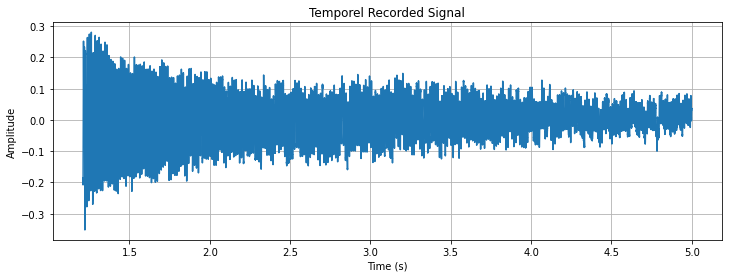

In [10]:
plt.figure(figsize=(12, 4))
plt.title("Temporel Recorded Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(times[62000:], mic[62000:])
plt.grid()
plt.show()


In [11]:

fs_mic = int(1/(times[1]-times[0]))

sd.play(mic[60000:], fs_mic)

In [34]:
from scipy.linalg import hankel

def HR(x, N : int, K : int):
 #input
    # x: signal
    # N: numbers of samples on the signal
    # K: sinus numbers   
    
    La = 2*N-1
    #creation of hankel matrix
    H = hankel(x[:N], x[N-1:La])
    H_h = H.conj()
    Rxx = 1/N*H*H_h

    # U1 as a base de signal subspace W
    U1, lam, U2 =  np.linalg.svd(H)
    
    W = U1[0:N, 0:2*K]
    w = (np.identity(2*K) - W.conj().T @ W) @ x[:2*K]

    return w

In [37]:
from tqdm import tqdm
def blocks(x_full : np.ndarray, window_length : float, hop_size : float, sampling_rate : int, K : int, n : int):
    # input
        # x_full: the full-length input signal
        # window_length: the window size (in seconds)
        # hop_size: the hop size (in seconds)
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: the number of sinusoids

    N_full = len(x_full)                    # the length of the signal (in samples)
    N = int(window_length*sampling_rate)    # window size (in samples)
    h = int(hop_size*sampling_rate)         # hop size (in samples)
    I = int((N_full-N)/h)                   # number of blocks
    
    x_0 = x_full[ : N]
    #delta   = np.zeros((I,K))
    #f       = np.zeros((I,K))
    w       = np.zeros((I,K))
    #alpha   = np.zeros((I,K), dtype=complex)
    #a       = np.zeros((I,K))
    #phi     = np.zeros((I,K))
    #W = np.zeros((I, K))
    #W[0] = W0
    #EdB     = np.zeros((I,K))

    for i in tqdm(range(I)):
        
        
        x_i = x_full[h*i:h*i+N]    # ith truncated signal
        w[i] = HR(x_i, N, K)
        

        #delta[i], f[i] = ESPRIT(x_i, n, K)
        #alpha[i], a[i], phi[i] = LeastSquares(x_i, delta[i], f[i])
        # EdB[i] = Energy(x[i], delta[i], a[i])

    return w #, EdB

[-1.41677625e-17 -3.76011706e-18 -2.41977184e-18 -9.20774409e-18
 -1.03841208e-17 -2.41899814e-18  2.52829615e-17  2.56055861e-17
  1.57193133e-17  2.23718242e-17  5.87566339e-18  1.95047211e-18
 -4.45600088e-18  1.81505192e-17 -2.19341820e-18  2.87141788e-18
  3.32329434e-17 -1.20702815e-17  1.12840847e-17  3.37664450e-18]


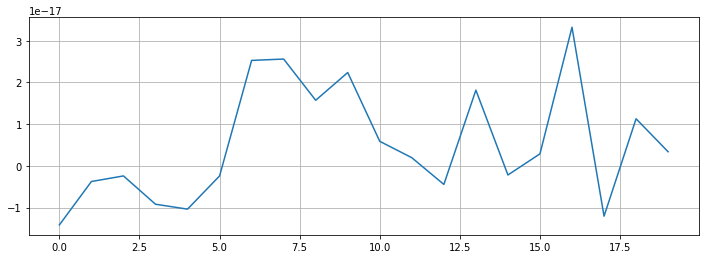

In [39]:
w = HR(mic[60000:], int(51200*0.05), 10)
#w = blocks(mic[60000:], 0.05, 0.01, 51200, 10, int(51200*0.05))

print(w)

plt.figure(figsize=(12, 4))

plt.plot(w)
plt.grid()
plt.show()

In [40]:
sd.play(w, fs_mic)

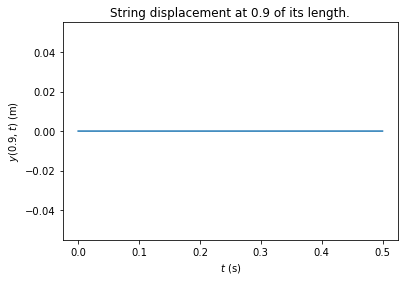

In [7]:
plt.figure()
plt.plot(t, y)
plt.xlabel("$t$ (s)")
plt.ylabel(f"$y({x_vis}, t)$ (m)")
plt.title(f"String displacement at {x_vis} of its length.")
plt.show()

In [16]:
def esti_fre_amort(W):
    W_down = W[0:n-1,:]
    W_up = W[1:n,:]
    Phi = np.dot(np.linalg.pinv(W_down),(W_up))
    eig_values = scipy.linalg.eig(Phi, left = False, right = False)
    
    delta_vecteur = np.log(np.abs(eig_values))
    f_vecteur = 1/(2*np.pi)*np.angle(eig_values)

    return delta_vecteur, f_vecteur

In [17]:
def LeastSquares(x,delta,f):
    N = len(x)
    t = np.array(range(N))
    k = delta+1j*2*np.pi*f
    tk = np.outer(t, k)
    alpha = np.dot(np.linalg.pinv(np.exp(tk)), x)
    a = abs(alpha)
    phi = np.angle(alpha)
    return a, phi, alpha

In [18]:
def ESPRIT(x,n,K):
    # x: signal synthétique
    # N: longueur du signal
    # K: combien de sinus
    # n-K : diemension de l'espace bruit
    # n: le nombre de ligne n de la matrice espace signal
    
    N = len(x)
    l = N - n + 1
    X = hankel(x[0:n], x[n-1:N])
    # Construction de la matrice de corrélation
    Rxx = 1/l * X @ X.conj().T
    W = esti_espace(Rxx, K)
    delta, f = esti_fre_amort(W)
    a, phi, amplitude = LeastSquares(x,delta,f)
    return delta, f, a, phi, amplitude

Fast adaptive ESPRIT 
In an adaptive context, the signal variations can be tracked by time-shifting the analysis window. The complexity
of the subspace estimation can be reduced by using a fast subspace
tracker which efficiently updates W (t).

1. ESTER

In [19]:
def ester_error(
    x: npt.NDArray[complex], n: int, p_max: int
) -> List[npt.NDArray[complex]]:
    """[summary]

    Still don't know if p_max whether chosen or estimated,
    and how.
    Don't discard the bogus p=0 case,
    because then the best ordre is the argmax!

    Args:
        x (npt.NDArray[complex]): [description]
        n (int): [description]
        p_max (int): Maximum ordre to consider, in [|1, n-2|]

    Returns:
        List[npt.NDArray[complex]]: Estimation error of p for p in [1, p_max]
    """
    # x: input signal
    # n: n: number of lines in the Hankel matrix S
    # K: ?
    assert (
        1 <= p_max < n - 1
    ), f"Maximum ordre p_max={p_max} should be less than n-1={n-1}."

    w, _ = esprit_ws(x, n, p_max)
    w_cap = [w[:, :p] for p in range(p_max + 1)]
    #
    # nus are (p)-vecs
    nu = [w_cap[p][-1].T.conj() for p in range(p_max + 1)]
    #
    psi_l = [None] * (p_max + 1)
    psi_r = [None] * (p_max + 1)
    psi_lr = [None] * (p_max + 1)
    ksi_cap = [np.zeros((n - 1, p), dtype=w_cap[0].dtype) for p in range(p_max + 1)]
    phi = [np.zeros(p, dtype=w_cap[0].dtype) for p in range(p_max + 1)]
    e = [np.zeros((p, p), dtype=w_cap[0].dtype) for p in range(p_max + 1)]
    for p in range(1, p_max + 1):
        # Recursive computation of e[p]
        # see Badeau et al. (2006) Table 1 for details on the algorithm
        w_cap_down_pm = w_cap[p - 1][:-1]
        w_cap_up_pm = w_cap[p - 1][1:]
        w_down_p = w_cap[p][:-1, p - 1]
        w_up_p = w_cap[p][1:, p - 1]
        # print(w_down_p.shape, w_up_p.shape)
        # 1. Update of the auxiliary matrix psi_mat[p]
        psi_r[p] = w_cap_down_pm.T.conj() @ w_up_p
        psi_l[p] = w_cap_up_pm.T.conj() @ w_down_p
        psi_lr[p] = w_down_p.T.conj() @ w_up_p
        # print(w_cap_up_pm.shape, w_down_p.shape)
        # 2. Update of the auxiliary matrix ksi_mat[p]
        # print(w_up_p.shape)
        # print(w_cap_down_pm.shape, psi_r[p].shape)
        # print(w_down_p.shape, psi_lr[p].shape)
        ksi_p = w_up_p - w_cap_down_pm @ psi_r[p] - w_down_p * psi_lr[p]
        # print(ksi_cap[p - 1].shape)
        # print(ksi_cap[p][:, :-1].shape)
        psi_l_p = psi_l[p]
        ksi_cap[p][:, :-1] = ksi_cap[p - 1] - np.outer(w_down_p, psi_l_p.conj())
        ksi_cap[p][:, -1] = ksi_p
        # 3. Computation of e[p] from ksi_cap[p]
        mu_p = nu[p][-1]
        phi[p][:-1] = phi[p - 1] + mu_p * psi_l[p]
        phi[p][-1] = psi_r[p].T.conj() @ nu[p - 1] + mu_p * psi_lr[p].conj()
        w_cap_down_p = w_cap[p][:-1]
        a = w_cap_down_p @ nu[p]
        e[p] = ksi_cap[p] - 1 / (1 - np.linalg.norm(nu[p], ord=2) ** 2) * np.outer(
            (w_cap_down_p @ nu[p]), phi[p].T.conj()
        )
    # discard p=0 bogus case.
    e = e[1:]
    return e

NameError: name 'npt' is not defined

2. FAPI, knowing order r, estimating W the spectral matrix

### Algorithme Fast Approximated Power Iteration (FAPI)

with the section Subspace Tracking
PAST (Projection Approximation Subspace TRACKIN)

the subspace tracker such as PAST provides a rank-one update for W(t)

In [20]:
def Adaptive(x : np.ndarray, n : int, r : float, fe : float, beta: float = 0.99):
    # n : number of lines in W
    # r : estimation by ESTER of the order
    # # n>r
    # fe: sampling frequency
    #  0 < β < 1 is the forgetting factor

    # computation of W(0), Z(0)
    W0 = np.zeros(n, r)
    W0[:r, :] = np.identity(r)
    W0[r:, :] = 0
    Z0 = np.identity(r)
    
    # time step
    NbEch = len(x)
    t = (np.arange(0, NbEch)/fe)
    W = []
    W.append(W0)
    # W = np.zeros((1, t))
    # W[0] = W0
    

    Z = []
    Z.append(Z0)
    #Z = np.zeros((1, t))
    #Z[0] = Z0

    psi = []
    Phi = []    # the list of Φ(t) 
    eigenvalues = []

    #e = np.zeros((1, t))   #e(t) , not sure about the dimension
    phi = np.zeros((1, t)) #Θ(t) , not sure about the dimension
    #e_point = np.zeros((1, t)) #e'(t) , not sure about the dimension

    #matrix dimensions : y(t), h(t), g(t)
    #y = np.zeros((n, r))
    #h = np.zeros((r, r))
    #g = np.zeros((2, r))
  
    for i in t:  #from 0 to t-1
        # PAST main section
        y = W[i].conj().T @ x[i+1]
        h = Z[i] @ y
        g = h / (beta + y.conj().T @ h)

        # API main section
        e = x[i+1] - W[i]@y #e(t)
        phi = (np.identity(r) + np.linalg.norm(e)**2 @ g @g.conj().T)**(-1/2)
        Z[i+1] = 1/beta * phi.conj().T @ (np.identity(r) - g @ y.conj().T)@Z[i] @ np.linalg.inv(phi.conj().T)
        W[i+1] = (W[i] + e[i+1] @ g.conj().T) @ phi[i+1]

        # FAPI main section (constants)
        sigma_sqaure = np.linalg.norm(x[i+1])**2 - np.linalg.norm(y)**2
        tho = sigma_sqaure/ (1 + sigma_sqaure*np.linalg.norm(g)**2 + np.sqrt(1 + sigma_sqaure*np.linalg.norm(g)**2))
        nu = 1 - tho*np.linalg.norm(g)**2

        #vectors
        y_point = nu*y + tho*g
        h_point = Z[i].conj().T @ y_point
        big_sigma = tho/nu * (Z[i]@g - (h_point.conj().T @ g)@ g)
        Z[i+1] = 1/beta * (Z[i] - g @ h_point.conj().T + big_sigma @ g.conj().T) 
        e_point = nu*x[i+1] - W[i] @ y_point
        # update rules
        W[i+1] = W[i] + e_point[i+1] @ g.conj().T
        
        W.append(W[i+1])
        Z.append(Z[i+1])

        #Adaptive computation of the spectral matrix
        W_down = W[i][0:-1, :]
        W_up = W[i][1:, :]
        e_minus = W_down.conj().T @ e_point[1:, ]
        e_plus = W_up.conj().T @ e_point[0:-1, :]
        epoint_plus = e_plus + g @ (e_point[1:, ].conj().T @ e_point[0:-1, :])
        psi = W_down.conj().T @ W_up  #psi[i]

        psi.append(psi)
        psi = psi + e_minus @ g.conj().T  + g @ epoint_plus.conj().T #psi[i+1], update rules for Ψ(t)

        nu = W[i+1][-1, :]            #last row of W(t),
        phi_phi = psi.conj().T @ nu   # ϕ(t)
        big_phi = psi + 1/(1 - np.linalg.norm(nu)**2) * nu @ phi_phi.conj().T  # Φ(t)
        
        Phi.append(big_phi)
        
        D = scipy.linalg.eig(big_phi, left = False, right = False)    # D, eigenvalues of big_phi
        eigenvalues.append(D) 
        # eigenvalues tracking


        
        ### Adaptive computation of the spectral matrix
        return W, eigenvalues  # W is the list [W0 W1 W2 W3......], D is the list of eigenvalue 
        

In [ ]:
# an iteration of FAST 

def FAST(W: np.matrix, Z: np.matrix, x_step: np.ndarray, beta: float, r: int):
    # input:
      # W : the spectral matrix at one time step
      # r: order of the estimation
    # PAST main section
    y = W.conj().T @ x_step      # x[i+1]
    h = Z @ y
    g = h / (beta + y.conj().T @ h)

    # API main section
    e = x_step - W@y #e(t)
    phi = (np.identity(r) + np.linalg.norm(e)**2 @ g @g.conj().T)**(-1/2)
    Z_new = 1/beta * phi.conj().T @ (np.identity(r) - g @ y.conj().T)@Z @ np.linalg.inv(phi.conj().T)
    W_new = (W + e @ g.conj().T) @ phi

    # FAPI main section (constants)
    sigma_sqaure = np.linalg.norm(x_step)**2 - np.linalg.norm(y)**2
    tho = sigma_sqaure/ (1 + sigma_sqaure*np.linalg.norm(g)**2 + np.sqrt(1 + sigma_sqaure*np.linalg.norm(g)**2))
    nu = 1 - tho*np.linalg.norm(g)**2
  #vectors
    y_point = nu*y + tho*g
    h_point = Z[i].conj().T @ y_point
    big_sigma = tho/nu * (Z[i]@g - (h_point.conj().T @ g)@ g)
    Z[i+1] = 1/beta * (Z[i] - g @ h_point.conj().T + big_sigma @ g.conj().T) 
    e_point = nu*x[i+1] - W[i] @ y_point
    # update rules
    W[i+1] = W[i] + e_point[i+1] @ g.conj().T
        
    W.append(W[i+1])
    Z.append(Z[i+1])

    #Adaptive computation of the spectral matrix
    W_down = W[i][0:-1, :]
    W_up = W[i][1:, :]
    e_minus = W_down.conj().T @ e_point[1:, ]
    e_plus = W_up.conj().T @ e_point[0:-1, :]
    epoint_plus = e_plus + g @ (e_point[1:, ].conj().T @ e_point[0:-1, :])
    psi = W_down.conj().T @ W_up  #psi[i]

    psi.append(psi)
    psi = psi + e_minus @ g.conj().T  + g @ epoint_plus.conj().T #psi[i+1], update rules for Ψ(t)

    nu = W[i+1][-1, :]            #last row of W(t),
    phi_phi = psi.conj().T @ nu   # ϕ(t)
    big_phi = psi + 1/(1 - np.linalg.norm(nu)**2) * nu @ phi_phi.conj().T  # Φ(t)
        
    Phi.append(big_phi)
      

   
    ### Adaptive computation of the spectral matrix
    return W # W is the list [W0 W1 W2 W3......], D is the list of eigenvalue 
        
    
    


    

In [9]:
#lambda = scipy.linalg.eig(big_phi, left = False, right = False)    # lambda, eigenvalues of Φ(t)

# This is a recursive computation of delta, f
def HRHATRAC(lam_matrix : np.ndarray, V: np.ndarray, phi : np.ndarray, mu_L : float = 0.99, mu_v : float = 0.99):
    # input:
       # lam_matrix : eigenvalues matrix of Φ(t), previous values, lambda(t-1)
       # V : eigenvectors matrix of Φ(t), previous values of V(t − 1)
       # phi : Φ(t-1)
       # EL :  estimation error
       # nu : 0 <  nu_L < 1,   0 <  nu_v < 1, 0.99 perhaps

   # iteration for lambda(t)
    # EL = lambda - np.diag(np.linalg.inv(V) @ phi @ V)
    lam_new = (1-mu_L)*lam_matrix + mu_L * np.diag(np.linalg.inv(V) @ phi @ V)

    # iteration for V(t)
    Ev = V - phi @ V @ np.linalg.inv(lam_new)
    V_new = (1 - mu_v) * V + mu_v * (phi @ V @ np.linalg.inv(lam_new) + phi.conj().T @ Ev @ np.linalg.inv(lam_new.conj().T))

    # estimation of frequency fk, dampling factor:
    poles = lam_new.diagonal()   # r values of zk
    
    delta = []   # a list contains r values of delta, delta_k , k from 1 to r
    f = []       # a list contains r values of frequencies, fk , k from 1 to r
    for i in range(r):
        delta.append(np.log(np.abs(poles[i])))
        f.append(1/(2*np.pi)*np.angle(poles[i]))

    return lam_new, V_new, delta, f, poles






In [ ]:
def recursive_decomposition(poles: np.ndarray, ):
    # input:
       # poles : array of zk


Adaptive computation of the eigenvalues

In [7]:
#G_point, big_Phi ,G = np.linalg.svd(D) , knowing the first value of D, indicate the first value of G_point_H
def eigenvalues(a_bar: np.ndarray, b_bar: np.ndarray, G_point: np.ndarray, G: np.ndarray, r: int, phi : np.ndarray, D: ):
    atilde_bar = G_point.conj().T @ a_bar
    btilde_bar = G.conj().T @ b_bar
     #phi_bar = np.identity(3) - btilde_bar.conj().T @ () #φ(z;t)_bar
    roots_list = scipy.linalg.eigvals(phi)  # an array list containing r values
    for k in np.arange(1, r+1):
        phi_k = np.identity(3) - btilde_bar.conj().T @ np.linalg.inv((roots_list[k]*np.identity(r) - D)) @ atilde_bar
        





    

SyntaxError: invalid syntax (683395875.py, line 2)

In [16]:
W = np.array([[1, 2, 3, 4, 5]])
Wup = W[0][1:]
Wdown = W[0][0:-1]

print(Wup)
print(Wdown)

[2 3 4 5]
[1 2 3 4]


In [11]:
W = np.identity(4)

Wdown = W[0:-1, :]
Wup = W[1:, :]
nu = W[-1, :]
print(W)
print(Wdown)
print(nu)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
[0. 0. 0. 1.]


In [1]:
def blocks(x_full : np.ndarray, window_length : float, hop_size : float, sampling_rate : int, n : int, K : int):
    # input
        # x_full: the full-length input signal
        # window_length: the window size (in seconds)
        # hop_size: the hop size (in seconds)
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: the number of sinusoids

    N_full = len(x_full)                    # the length of the signal (in samples)
    N = int(window_length*sampling_rate)    # window size (in samples)
    h = int(hop_size*sampling_rate)         # hop size (in samples)
    I = int((N_full-N)/h)                   # number of blocks
    
    x_0 = x_full[ : N]
    Rxx, W0 = obtain_matrix(x_0, n)
    delta   = np.zeros((I,K))
    f       = np.zeros((I,K))
    alpha   = np.zeros((I,K), dtype=complex)
    a       = np.zeros((I,K))
    phi     = np.zeros((I,K))
    W = np.zeros((I, K))
    W[0] = W0
    # EdB     = np.zeros((I,K))

    for i in tqdm(range(I)):
        
        W[i+1] = W[i] + 
        #x_i = x_full[h*i:h*i+N]     ith truncated signal
        
        

        #delta[i], f[i] = ESPRIT(x_i, n, K)
        #alpha[i], a[i], phi[i] = LeastSquares(x_i, delta[i], f[i])
        # EdB[i] = Energy(x[i], delta[i], a[i])

    return delta, f, alpha, a, phi #, EdB

NameError: name 'np' is not defined

In [5]:
def adap_spectral_matrix(x_full : np.ndarray, n : int, window_length : float, hop_size : float, sampling_rate : int):
     # input
        # x_full: the full-length input signal
        # window_length: the window size (in seconds)
        # hop_size: the hop size (in seconds)
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: the number of sinusoids
 
    Rxx, W = obtain_matrix(x_full, n)
    N_full = len(x_full)                    # the length of the signal (in samples)
    N = int(window_length*sampling_rate)    # window size (in samples)
    h = int(hop_size*sampling_rate)         # hop size (in samples)
    I = int((N_full-N)/h)                   # number of blocks

    for i in tqdm(range(I)):
        hui

    

    

    

adaptive computation of the spectral matrix

In [14]:
#Programme permettant                                                                                                %
#  -Lire les donnees d'acceleration                                                                                  %
#  -Faire une FFT (du signal                                                                                          %
#  -Faire un calcul avec l'algorithme ESPRIT                                                                         %
#  -Export des resultats sous forme d'un fichier text lisible dans un tableur   

signal temporel

In [15]:
def nextpow2(i):
    n = 1
    while n < i:
        n *= 2
    return n

In [16]:
import scipy
from scipy.signal import lfilter

In [17]:
#FIR 2
def filtre(signal,temps,fe,f_cen,f_delta,ordre):
    Nb = len(signal)
    ## calcul FFT
    Nfft = 2**nextpow(Nb)
    signal= np.fft.fft(signal, Nfft)
    freq = np.fft.fftfreq(Nfft, 1/fe)
    
    ## Translation du signal centré à fréquence nulle
    signal1 = np.multiply(signal, np.exp(-1j*2*np.pi*f_cen*temps))
    signal1_fft= np.fft.fft(signal1, Nfft)
    
    #FIR windowing
    cut_f = f_delta/2/(fe/2) # entre 0 et 1
    b = scipy.signal.firwin(ordre+1,cut_f)
    filtre = np.fft.fft(b, Nfft)
    #windowed signal2
    signal2 = lfilter(b, 1, signal1)
    signal2_fft = np.fft.fft(signal2, Nfft)
    return signal2, b

In [18]:
def FIR_3(signal,temps,fe,f_cen,f_delta,ordre): 
    Nb = len(signal)
    ## calcul FFT
    Nfft = 2**nextpow(Nb)
    signal_FFT= np.fft.fft(signal, Nfft)
    axe_freq1 = np.arange(-fe/2, fe/2, fe/Nfft)
    
    freq_1 = (f_cen - f_delta/2)/(fe/2)
    freq_2 = (f_cen + f_delta/2)/(fe/2)
    b = scipy.signal.firwin(ordre+1,[freq_1, freq_2])
    filtre = np.fft.fft(b, Nfft)
    
    signal_filtre = lfilter(b, 1, signal)
    L = len(b)
    signal_fil_tron = signal_filtre[L:] # L ou L-1 
    Nfft2 = 2**nextpow(len(signal_fil_tron))
    signal_FFT2_tron= np.fft.fft(signal_fil_tron, Nfft2)
    axe_freq2 = np.arange(-fe/2, fe/2, fe/Nfft2)
    temps2 = temps[(L+1)/2: len(signal_fil_tron) + (L+1)/2]
    
    return signal_filtre, signal_fil_tron, b

In [19]:
def deci(signal,temps,fe,R):
    fe_deci = fe/R
    t = np.arange(0, -1, R)
    signal_deci = signal[::R]
    temps_deci = temps[::R]
    Nb = len(signal) 
    N_deci = len(signal_deci)
    Nfft = 2**nextpow2(Nb)
    Nfft_deci = 2**nextpow2(N_deci)
    freq = np.arange(-fe/2, fe/2, fe/Nfft)
    freq_deci = np.arange(-fe_deci/2, fe_deci/2, fe_deci/Nfft_deci)
    return signal_deci, fe_deci

In [20]:
def energie(delta, a, N):
    # Fonction permettant le calcul de l'énergie pour chaque composante extraite par la méthode ESPRIT. Le signal d'étude est de longueur 
    #N : longueur du signal d'étude
    E = []
    n = np.arange(0, N)
    for i in range(0, len(delta)):
        for j in n:
            E += a[i]**2*np.exp(-2*abs(delta[i])*n[j])
    Emax = max(E)
    EdB = 10*np.log(E/Emax)
    return E, EdB

In [21]:
def ESTER(x, n, K):
    #x: signal
    # calcul de fonction d'erreur inverse
    N = len(x)
    l = N-n+1
    X = hankel(x[:n], x[n-1:N])
    XH = X.conj().T
    Rxx = 1/l*X*XH
    U1, lam, U =  np.linalg.svd(Rxx)
    norm_E = []
    for i in range(K):
        W = U1[: n, :i]
        W_down = W[0:n-1,:]
        W_up = W[1:n,:]
        Phi = np.dot(np.linalg.pinv(W_down),(W_up))
        E = W_up - np.dot(W_down, Phi)
        Valeur,_,_ = np.linalg.svd(E)
        norm_E = max(Valeur)  # not sure here
    return norm_E

In [22]:
def synthesis(temps,delta,f,a,phi):
    Nb = len(delta)
    N = len(temps)
    signal = np.zeros(1, N)
    Te = temps[1] - temps[0]
    fe = 1/Te
    Nfft = 2**nextpow2(N)
    freq = np.arange(-fe/2, fe/2, fe/Nfft)
    for i in range(nb_composante):
        signal_ins = a[i]*np.multiply(np.exp(delta[i]*temps), np.cos(2*np.pi*temps*f[i]+ phi[i]))
        signal += signal_ins
    
    return signal

In [23]:
# sachant déjà le signal, signal est le signal numérique à décimer
def program(signal, fe, t_i, t_f, f_cen, f_delta, ordre, R, n, K, nb_composante):
    #t_i: temps initial
    #t_f: temps final d'étude
    #ss : signal d'étude
    #f_cen : fréquence centrale
    #f_delta : 
    #R : step size
    Te = 1/fe
    ss = signal[np.floor(t_i*fe) : np.floor(t_f*fe)];
    temps = np.arange(0, Te**((np.floor(t_f*fe)-np.floor(t_i*fe))), Te)  #Decalage temporel du signal
    #Te = temps[1] - temps[0]
    #fe = 1/Te
    # (temps, ss), le signal temporel en représentation
    Nb = len(ss) # nombre de points du signal
    
    ## calcul FFT
    Nfft = 2**nextpow(Nb)
    signal= np.fft.fft(ss, Nfft)
    freq = np.fft.fftfreq(Nfft, 1/fe)
    # signal filtré
    s, b = filtre(ss, temps, fe, f_cen, f_delta, ordre)
    L_n = len(b)
    s = s[L_n:]
    retard = (L_n+1)/2*Te
    temps_filtre = temps[(L_n+1)/2: (len(s)+(L_n+1)/2)]
    
    #decimation du signal
    signal_deci, fe_deci = deci(signal,temps,fe,R)
    temps_deci = temps_filtre[::R]
    
    #ESPRIT 
    # n = np.floor(len(Signal_deci)/3)
    # K=50
    delta, f, a, phi, amp = ESPRIT(signal_deci, n, K)
    f, h = scipy.signal.freqz(b, 1) #H????
    f = f*fe_deci+f_cen
    delta = delta*fe_deci
    
    amp = 2*amp
    amp = np.multiply(amp, np.exp((abs(delta)-1j*2*np.pi*(f-f_cen))*retard))
    a = abs(amp)
    phi = np.angle(amp)
    
    EdB_sort = EdB.sort(axis=1)
    index = EdB.sort(axis=1)
    index = np.flip(index) 
    a = a[index]
    f = f[index]
    delta = delta[index]
    phi = phi[index]
    EdB = EdB[index]
    #np.argwhere(EdB>-40)
    print('frequency:', str(f[np.argwhere(EdB>-40)] ))
    print('damping', str(delta[np.argwhere(EdB>-40)] ))
    print('amplitude', str(a[np.argwhere(EdB>-40)] ))
    print('phase', str(phi[np.argwhere(EdB>-40)] ))
    
    norm_E = ESTER(signal_deci, n, K)
    # vous pouvez ajouter les figures
    signal_filtre, signal_fil_tron, b = FIR_3(signal,temps,fe,f_cen,f_delta,ordre)
    
    signal_syn = synthesis(temps, delta[: nb_composante], f[: nb_composante], a[: nb_composante], phi[: nb_composante])
    
    # il faut comparer signal_syn et signal_fil_tron